In [44]:
import torch
import torch.nn.functional as F
import ast
import pandas as pd
from sklearn.model_selection import train_test_split

In [86]:
df1 = pd.read_csv("/Users/pranavtyagi/Projects/masterthesis/data/predictions/feb/analysis_metrics.csv")

In [87]:
train_data, temp_data = train_test_split(df1, test_size=0.3, random_state=42)
val_data, df = train_test_split(temp_data, test_size=1/3, random_state=42)

In [88]:
df.columns

Index(['conversation_id', 'tweet_text', 'roberta-large-predictions',
       'mapped_predictions', 'averaged_predictions',
       'cosine_similarity_tweet_replies', 'clip_predictions',
       'cosine_similarity_clip_replies', 'cosine_similarity_clip_tweet',
       'matched_filename', 'tweet_distribution', 'average_reply_distribution',
       'clip_distribution', 'clip_tweet_dist', 'cosine_similarity_multi',
       'jsd', 'jsd_image', 'jsd_multi', 'jsd_image_reply', 'tweet_entropy',
       'reply_entropy', 'multi_entropy'],
      dtype='object')

In [90]:
def parse_line(predictions_str, labels_str):
    try:
        predictions_dict = ast.literal_eval(predictions_str)
        labels_dict = ast.literal_eval(labels_str)
        
        # Convert to tensors
        probs = torch.tensor(list(predictions_dict.values()), dtype=torch.float32)
        labels = torch.tensor(list(labels_dict.values()), dtype=torch.float32)
        return probs, labels
    except (SyntaxError, ValueError):
        return None, None

prediction_columns = ['tweet_distribution', 'clip_distribution', 'clip_tweet_dist'] 
kl_divergences_dict = {}
mean_squared_errors_dict = {}

for pred_col in prediction_columns:
    kl_divergences = []
    mean_squared_errors = []
    
    for _, row in df.iterrows():
        probs, labels = parse_line(row[pred_col], row['average_reply_distribution'])
        if probs is None or labels is None:
            continue  # Skip invalid rows

        # Ensure the tensors are properly normalized
        probs = probs / probs.sum()  # Convert to valid probability distribution
        labels = labels / labels.sum()  # Normalize labels as well

        batch_kl_divergences = F.kl_div(probs.log(), labels, reduction='sum').item()
        batch_mse = F.mse_loss(probs, labels, reduction='mean').item()

        kl_divergences.append(batch_kl_divergences)
        mean_squared_errors.append(batch_mse)
    
    # Store results in dictionary
    kl_divergences_dict[f'KL_Divergence_{pred_col}'] = kl_divergences
    mean_squared_errors_dict[f'MSE_{pred_col}'] = mean_squared_errors

# Ensure DataFrame dimensions match
df = df.iloc[:len(kl_divergences)]  

# Add results to DataFrame
for key, values in kl_divergences_dict.items():
    df[key] = values
for key, values in mean_squared_errors_dict.items():
    df[key] = values

/var/folders/yp/dcvlqkwd0jgdyxjp_q1f8w440000gn/T/ipykernel_37125/3403478139.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = values
/var/folders/yp/dcvlqkwd0jgdyxjp_q1f8w440000gn/T/ipykernel_37125/3403478139.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = values
/var/folders/yp/dcvlqkwd0jgdyxjp_q1f8w440000gn/T/ipykernel_37125/3403478139.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [91]:
df

,conversation_id,tweet_text,roberta-large-predictions,mapped_predictions,averaged_predictions,cosine_similarity_tweet_replies,clip_predictions,cosine_similarity_clip_replies,cosine_similarity_clip_tweet,matched_filename,...,jsd_image_reply,tweet_entropy,reply_entropy,multi_entropy,KL_Divergence_tweet_distribution,KL_Divergence_clip_distribution,KL_Divergence_clip_tweet_dist,MSE_tweet_distribution,MSE_clip_distribution,MSE_clip_tweet_dist
198,1096448460583260161,Our students took the lead in the fight agains...,"[('optimism', 0.9810001850128174), ('joy', 0.8...","[('fear', 0.011164323351160214), ('disgust', 0...","[('fear', 0.06047392221213688), ('disgust', 0....",0.339843,"[('anger', 0.5489631), ('disgust', 0.13539463)...",0.736023,0.115306,id_1096448460583260161_2019-02-15.jpg,...,0.332901,0.894837,2.411120,2.119343,2.127488,0.687516,0.409579,0.105137,0.052507,0.027742
332,1096541711847833601,Why are Arctic fisheries under threat due to c...,"[('fear', 0.9263613820075989), ('sadness', 0.4...","[('fear', 0.48925698009041596), ('disgust', 0....","[('fear', 0.08450050080627194), ('disgust', 0....",0.542696,"[('anger', 0.31692), ('sadness', 0.2740194), (...",0.494711,0.629708,id_1096541711847833601_2019-02-15.jpg,...,0.481270,2.008410,2.096574,2.366826,0.526433,0.695098,0.560914,0.047499,0.042861,0.037811
43,1095943507779305472,Everywhere there are signs that we have reache...,"[('fear', 0.871435284614563), ('sadness', 0.61...","[('fear', 0.49675462303614526), ('disgust', 0....","[('fear', 0.0318985875978461), ('disgust', 0.0...",0.269678,"[('surprise', 0.3934697), ('disgust', 0.300639...",0.662813,0.344603,id_1095943507779305472_2019-02-14.jpg,...,0.486785,1.990189,1.887569,2.389172,1.327314,0.766100,0.974720,0.080078,0.053326,0.040766
425,1096757339749679104,Editorial: Mitch McConnell doubtlessly underst...,"[('disgust', 0.7204411625862122), ('anticipati...","[('fear', 0.13702042579834062), ('disgust', 0....","[('fear', 0.21606504528862117), ('disgust', 0....",0.887880,"[('anger', 0.65399826), ('disgust', 0.11806615...",0.325795,0.538123,id_1096757339749679104_2019-02-16.jpg,...,0.590347,2.317214,2.420347,2.240631,0.293463,0.485763,0.436029,0.007880,0.042610,0.028290
1379,1100430895083868160,This photo worries me #February #climatechange...,"[('fear', 0.9942943453788757), ('pessimism', 0...","[('fear', 0.7040371969671779), ('disgust', 0.0...","[('fear', 0.4635530298826913), ('disgust', 0.2...",0.890262,"[('anger', 0.52634525), ('sadness', 0.15412398...",0.607254,0.317794,id_1100430895083868160_2019-02-26.jpg,...,0.396548,1.433912,2.030842,2.088118,0.515442,0.445560,0.122950,0.019670,0.009042,0.006012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,1100873906594959360,27th February 2018 vs 27th February 2019. But ...,"[('disgust', 0.6010696291923523), ('anticipati...","[('fear', 0.041227948416333864), ('disgust', 0...","[('fear', 0.10460124212115876), ('disgust', 0....",0.743647,"[('disgust', 0.36531302), ('anger', 0.30135813...",0.660809,0.952324,id_1100873906594959360_2019-02-27.jpg,...,0.433890,2.064323,2.385512,2.111497,0.398629,0.581145,0.456085,0.022315,0.030722,0.024026
1106,1098639572316160001,#Women4Climate thanks [USER] for this event pr...,"[('optimism', 0.9892467856407166), ('joy', 0.9...","[('fear', 0.011701253456356545), ('disgust', 0...","[('fear', 0.047613872014641734), ('disgust', 0...",0.155138,"[('anger', 0.3910448), ('sadness', 0.31996816)...",0.777300,0.047288,id_1098639572316160001_2019-02-21.jpg,...,0.351054,0.806308,2.124179,2.207442,3.560697,1.384152,0.632145,0.140824,0.038910,0.041484
1420,1100522521047252993,"Arthur’s Seat 2018, vs Arthur’s Seat 2019.Clim...","[('optimism', 0.5123183727264404), ('disgust',...","[('fear', 0.16227357463072134), ('disgust', 0....","[('fear', 0.12573714559088056), ('disgust', 0....",0.961935,"[('anger', 0.5869566), ('fear', 0.11374291), (...",0.701974,0.539706,id_1100522521047252993_2019-02-26.jpg,...,0.372500,2.484331,2.475295,

In [92]:
df.to_csv("results_feb.csv", index=False)

In [93]:
df=pd.read_csv("results_aug.csv")

In [94]:
df

,conversation_id,tweet_text,roberta-large-predictions,averaged_predictions,mapped_predictions,cosine_similarity_tweet_replies,clip_predictions,cosine_similarity_clip_replies,cosine_similarity_clip_tweet,similarity_bin,...,jsd_image_reply,tweet_entropy,reply_entropy,multi_entropy,KL_Divergence_tweet_distribution,KL_Divergence_clip_distribution,KL_Divergence_clip_tweet_dist,MSE_tweet_distribution,MSE_clip_distribution,MSE_clip_tweet_dist
0,1166008123263475712,#AlTenoorOverflow #Africafires#Angola#Zambia#T...,"[('anticipation', 0.18425847589969635), ('ange...","[('anger', 0.06943728003861536), ('fear', 0.48...","[('anger', 0.21514055782994462), ('fear', 0.15...",0.549003,"[('fear', 0.3789367), ('anger', 0.26606992), (...",0.805413,0.782031,0.6-0.8,...,0.372395,2.392732,1.894418,2.397760,0.659006,0.581619,0.479665,0.043325,0.035957,0.027494
1,1158024573243334657,Sage words from co-founder of the [USER] [USER...,"[('disgust', 0.9435292482376099), ('anger', 0....","[('anger', 0.12345011625812803), ('fear', 0.11...","[('anger', 0.3335972931162361), ('fear', 0.058...",0.741571,"[('surprise', 0.3979619), ('disgust', 0.192632...",0.718972,0.667360,0.6-0.8,...,0.410953,2.157165,2.474610,2.316720,0.340141,0.938059,0.299686,0.020341,0.028038,0.013925
2,1161462789795221504,So I know they are #ClimateChangedeniers.But I...,"[('disgust', 0.9702249765396118), ('anger', 0....","[('anger', 0.2677825772720873), ('fear', 0.104...","[('anger', 0.33216690109041486), ('fear', 0.12...",0.970299,"[('surprise', 0.39039624), ('anger', 0.3012097...",0.632252,0.620269,0.6-0.8,...,0.428990,2.045863,2.225498,2.320151,0.060455,0.407387,0.160361,0.002703,0.021938,0.008429
3,1163191441306398721,Is Climate Change real? That’s not up to us to...,"[('anticipation', 0.9576886892318726), ('optim...","[('anger', 0.15045814225567147), ('fear', 0.07...","[('anger', 0.08089625640880886), ('fear', 0.07...",0.938699,"[('anger', 0.45440218), ('disgust', 0.20690694...",0.622256,0.432749,0.4-0.6,...,0.458495,1.965242,2.367059,2.300349,0.113712,0.845224,0.113358,0.007616,0.030372,0.005374
4,1164233724772462592,Why isn’t everyone doing this?[URL] [USER] #cl...,"[('optimism', 0.792866587638855), ('sadness', ...","[('anger', 0.12882927371328437), ('fear', 0.17...","[('anger', 0.0580449479990004), ('fear', 0.028...",0.838172,"[('anger', 0.5921461), ('sadness', 0.21181808)...",0.565835,0.321836,0.2-0.4,...,0.516915,2.110238,2.389405,2.282167,0.305661,1.565800,0.283622,0.014076,0.058481,0.011233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,1164909872409972736,"The diary of young ⁦[USER]⁩, 1994: never not d...","[('sadness', 0.9923811554908752), ('pessimism'...","[('anger', 0.029483021896698425), ('fear', 0.0...","[('anger', 0.011742866453751184), ('fear', 0.4...",0.501565,"[('fear', 0.418049), ('anger', 0.24365497), ('...",0.565783,0.583955,0.4-0.6,...,0.526592,1.593220,2.256675,2.139830,1.403162,0.933948,0.691342,0.054487,0.042847,0.034676
731,1157266962671689733,If terraforming is the transformation of anoth...,"[('fear', 0.5643811225891113), ('anticipation'...","[('anger', 0.08946653180516631), ('fear', 0.15...","[('anger', 0.06552404663067052), ('fear', 0.31...",0.636690,"[('anger', 0.5833039), ('sadness', 0.21278773)...",0.325762,0.357303,0.2-0.4,...,0.630028,2.188562,2.347650,2.308614,0.857563,1.886015,1.112878,0.028917,0.066930,0.032766
732,1162437587715289089,I’m with 700+ Catholic sisters at #LCWR2019. W...,"[('optimism', 0.9784810543060303), ('sadness',...","[('anger', 0.004858315480424416), ('fear', 0.0...","[('anger', 0.06499159918398285), ('fear', 0.12...",0.932122,"[('disgust', 0.36011955), ('anger', 0.34713572...",0.084196,0.287512,0.2-0.4,...,0.879451,2.052232,0.572612,2.439128,0.391660,3.720033,0.980267,0.031450,0.179255,0.084364
733,1159941018764173317,What an adventure! Three and a half years goes...,"[('joy', 0.9972921013832092), ('optimism', 0.8...","[('anger', 0.17794349822853445), ('fear', 0.03...","[('anger', 0.

In [95]:
df.columns

Index(['conversation_id', 'tweet_text', 'roberta-large-predictions',
       'averaged_predictions', 'mapped_predictions',
       'cosine_similarity_tweet_replies', 'clip_predictions',
       'cosine_similarity_clip_replies', 'cosine_similarity_clip_tweet',
       'similarity_bin', 'matched_filename', 'tweet_distribution',
       'average_reply_distribution', 'clip_distribution', 'clip_tweet_dist',
       'cosine_similarity_multi', 'jsd', 'jsd_image', 'jsd_multi',
       'jsd_image_reply', 'tweet_entropy', 'reply_entropy', 'multi_entropy',
       'KL_Divergence_tweet_distribution', 'KL_Divergence_clip_distribution',
       'KL_Divergence_clip_tweet_dist', 'MSE_tweet_distribution',
       'MSE_clip_distribution', 'MSE_clip_tweet_dist'],
      dtype='object')

In [119]:
df1= pd.read_csv("/Users/pranavtyagi/Projects/masterthesis/data/predictions/aug/test_predictions_with_metrics_text.csv")
df2= pd.read_csv("/Users/pranavtyagi/Projects/masterthesis/data/predictions/aug/test_predictions_with_metrics_image.csv")
df3= pd.read_csv("/Users/pranavtyagi/Projects/masterthesis/data/predictions/aug/test_predictions_with_metrics_multi.csv")

In [120]:
merged_df = df1.merge(df2, on='conversation_id')

In [127]:
merged_df

,conversation_id,predictions_text_base,cosine_similarity_model_text_base,kl_divergence_text_base,mean_squared_error_text_base,predictions_image_base,cosine_similarity_model_image_base,kl_divergence_image_base,mean_squared_error_image_base,predictions_multi_base,cosine_similarity_model_multi_base,kl_divergence_multi_base,mean_squared_error_multi_base
0,1166008123263475712,"[('anger', 0.17008963227272034), ('sadness', 0...",0.617451,0.596990,0.035849,"[('anger', 0.11810187250375748), ('sadness', 0...",0.510256,0.757818,0.045332,"[('anger', 0.10888910293579102), ('sadness', 0...",0.468703,0.843957,0.049363
1,1158024573243334657,"[('anger', 0.16087716817855835), ('sadness', 0...",0.920432,0.079872,0.004975,"[('anger', 0.13490606844425201), ('sadness', 0...",0.996235,0.006962,0.000267,"[('anger', 0.1712423413991928), ('sadness', 0....",0.966738,0.039413,0.002149
2,1161462789795221504,"[('anger', 0.16136960685253143), ('sadness', 0...",0.745284,0.357470,0.018154,"[('anger', 0.13151054084300995), ('sadness', 0...",0.724121,0.373151,0.019820,"[('anger', 0.18524488806724548), ('sadness', 0...",0.825245,0.270557,0.012765
3,1163191441306398721,"[('anger', 0.17034029960632324), ('sadness', 0...",0.831767,0.204059,0.011251,"[('anger', 0.17220427095890045), ('sadness', 0...",0.936768,0.065914,0.004436,"[('anger', 0.15097835659980774), ('sadness', 0...",0.980087,0.020357,0.001476
4,1164233724772462592,"[('anger', 0.1831539273262024), ('sadness', 0....",0.886504,0.157142,0.007363,"[('anger', 0.13731467723846436), ('sadness', 0...",0.777628,0.304395,0.015191,"[('anger', 0.12437426298856735), ('sadness', 0...",0.734397,0.374825,0.018336
...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,1164909872409972736,"[('anger', 0.17293518781661987), ('sadness', 0...",0.742247,0.343101,0.018812,"[('anger', 0.1053723692893982), ('sadness', 0....",0.793000,0.242755,0.016604,"[('anger', 0.10436020791530609), ('sadness', 0...",0.852124,0.169199,0.011279
731,1157266962671689733,"[('anger', 0.19197547435760498), ('sadness', 0...",0.876641,0.136145,0.008820,"[('anger', 0.12357351928949356), ('sadness', 0...",0.959709,0.053473,0.003055,"[('anger', 0.12282855808734894), ('sadness', 0...",0.932210,0.069589,0.004986
732,1162437587715289089,"[('anger', 0.15329782664775848), ('sadness', 0...",0.508829,1.256120,0.103514,"[('anger', 0.11171422898769379), ('sadness', 0...",0.818509,0.648870,0.057328,"[('anger', 0.11640714108943939), ('sadness', 0...",0.850919,0.584112,0.050878
733,1159941018764173317,"[('anger', 0.12963734567165375), ('sadness', 0...",0.907309,0.126229,0.006752,"[('anger', 0.16758503019809723), ('sadness', 0...",0.971827,0.039184,0.002246,"[('anger', 0.06847141683101654), ('sadness', 0...",0.899217,0.172037,0.012215


In [122]:
merged_df.rename(columns={"cosine_similarity_model_x": "cosine_similarity_model_text_base", "cosine_similarity_model_y": "cosine_similarity_model_image_base","kl_divergence_x" : "kl_divergence_text_base", "kl_divergence_y":"kl_divergence_image_base", "mean_squared_error_x": "mean_squared_error_text_base", "mean_squared_error_y":"mean_squared_error_image_base","predictions_x":"predictions_text_base", "predictions_y":"predictions_image_base"}, inplace=True)

In [124]:
merged_df = merged_df.merge(df3, on='conversation_id')

In [126]:
merged_df.rename(columns={"cosine_similarity_model": "cosine_similarity_model_multi_base","kl_divergence" : "kl_divergence_multi_base", "mean_squared_error": "mean_squared_error_multi_base","predictions":"predictions_multi_base"}, inplace=True)

In [138]:
merged_df

,conversation_id,predictions_text,cosine_similarity_model_text,kl_divergence_text,mean_squared_error_text,predictions_image,cosine_similarity_model_image,kl_divergence_image,mean_squared_error_image,predictions_multi,cosine_similarity_model_multi,kl_divergence_multi,mean_squared_error_multi
0,1096448460583260161,"[('anger', 0.15004052221775055), ('sadness', 0...",0.946335,0.071573,0.003591,"[('anger', 0.08058871328830719), ('sadness', 0...",0.698000,0.291042,0.023368,"[('anger', 0.06251640617847443), ('sadness', 0...",0.572058,0.465023,0.040149
1,1096541711847833601,"[('anger', 0.18943582475185394), ('sadness', 0...",0.661549,0.438556,0.029255,"[('anger', 0.08634641021490097), ('sadness', 0...",0.644016,0.405440,0.032207,"[('anger', 0.10931407660245895), ('sadness', 0...",0.769702,0.281330,0.020871
2,1095943507779305472,"[('anger', 0.20723669230937958), ('sadness', 0...",0.645878,0.560645,0.032595,"[('anger', 0.09861933439970016), ('sadness', 0...",0.874241,0.248578,0.013387,"[('anger', 0.10328623652458191), ('sadness', 0...",0.860980,0.262726,0.014989
3,1096757339749679104,"[('anger', 0.17028899490833282), ('sadness', 0...",0.903381,0.122912,0.006163,"[('anger', 0.10613662004470825), ('sadness', 0...",0.828795,0.211208,0.011112,"[('anger', 0.10246411710977554), ('sadness', 0...",0.841554,0.204232,0.010192
4,1100430895083868160,"[('anger', 0.19009549915790558), ('sadness', 0...",0.788205,0.318755,0.019081,"[('anger', 0.0764935314655304), ('sadness', 0....",0.386800,0.909694,0.056253,"[('anger', 0.0958344042301178), ('sadness', 0....",0.518807,0.703300,0.040995
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1100873906594959360,"[('anger', 0.17107778787612915), ('sadness', 0...",0.794825,0.228380,0.013849,"[('anger', 0.1232147291302681), ('sadness', 0....",0.937599,0.066870,0.004488,"[('anger', 0.0943947434425354), ('sadness', 0....",0.889753,0.124676,0.007701
164,1098639572316160001,"[('anger', 0.13212314248085022), ('sadness', 0...",0.761314,0.319492,0.019725,"[('anger', 0.061768513172864914), ('sadness', ...",0.410181,0.802232,0.058960,"[('anger', 0.05107546225190163), ('sadness', 0...",0.364953,0.898039,0.068457
165,1100522521047252993,"[('anger', 0.1754831224679947), ('sadness', 0....",0.950110,0.064334,0.003066,"[('anger', 0.12668803334236145), ('sadness', 0...",0.953454,0.049281,0.002902,"[('anger', 0.07812617719173431), ('sadness', 0...",0.972629,0.037406,0.001757
166,1096408542297423872,"[('anger', 0.13744036853313446), ('sadness', 0...",0.878683,0.139792,0.008566,"[('anger', 0.07437614351511002), ('sadness', 0...",0.662158,0.329319,0.026832,"[('anger', 0.047963209450244904), ('sadness', ...",0.487106,0.588370,0.051766


In [140]:
merged_df = pd.read_csv("baseline_aug.csv")

In [141]:
metric_columns = [
    "cosine_similarity_model_text", "kl_divergence_text", "mean_squared_error_text",
    "cosine_similarity_model_image", "kl_divergence_image", "mean_squared_error_image",
    "cosine_similarity_model_multi", "kl_divergence_multi", "mean_squared_error_multi"
]

# Compute average values
averages = merged_df[metric_columns].mean().reset_index()

In [142]:
averages.columns = ['Metric', 'Average Value']

In [143]:
averages

,Metric,Average Value
0,cosine_similarity_model_text,0.728624
1,kl_divergence_text,0.515149
2,mean_squared_error_text,0.034614
3,cosine_similarity_model_image,0.817100
4,kl_divergence_image,0.358067
5,mean_squared_error_image,0.024206
6,cosine_similarity_model_multi,0.830667
7,kl_divergence_multi,0.327058
8,mean_squared_error_multi,0.021874


In [151]:
df = pd.read_csv("results_feb.csv")

In [145]:
df

,conversation_id,tweet_text,roberta-large-predictions,averaged_predictions,mapped_predictions,cosine_similarity_tweet_replies,clip_predictions,cosine_similarity_clip_replies,cosine_similarity_clip_tweet,similarity_bin,...,jsd_image_reply,tweet_entropy,reply_entropy,multi_entropy,KL_Divergence_tweet_distribution,KL_Divergence_clip_distribution,KL_Divergence_clip_tweet_dist,MSE_tweet_distribution,MSE_clip_distribution,MSE_clip_tweet_dist
0,1166008123263475712,#AlTenoorOverflow #Africafires#Angola#Zambia#T...,"[('anticipation', 0.18425847589969635), ('ange...","[('anger', 0.06943728003861536), ('fear', 0.48...","[('anger', 0.21514055782994462), ('fear', 0.15...",0.549003,"[('fear', 0.3789367), ('anger', 0.26606992), (...",0.805413,0.782031,0.6-0.8,...,0.372395,2.392732,1.894418,2.397760,0.659006,0.581619,0.479665,0.043325,0.035957,0.027494
1,1158024573243334657,Sage words from co-founder of the [USER] [USER...,"[('disgust', 0.9435292482376099), ('anger', 0....","[('anger', 0.12345011625812803), ('fear', 0.11...","[('anger', 0.3335972931162361), ('fear', 0.058...",0.741571,"[('surprise', 0.3979619), ('disgust', 0.192632...",0.718972,0.667360,0.6-0.8,...,0.410953,2.157165,2.474610,2.316720,0.340141,0.938059,0.299686,0.020341,0.028038,0.013925
2,1161462789795221504,So I know they are #ClimateChangedeniers.But I...,"[('disgust', 0.9702249765396118), ('anger', 0....","[('anger', 0.2677825772720873), ('fear', 0.104...","[('anger', 0.33216690109041486), ('fear', 0.12...",0.970299,"[('surprise', 0.39039624), ('anger', 0.3012097...",0.632252,0.620269,0.6-0.8,...,0.428990,2.045863,2.225498,2.320151,0.060455,0.407387,0.160361,0.002703,0.021938,0.008429
3,1163191441306398721,Is Climate Change real? That’s not up to us to...,"[('anticipation', 0.9576886892318726), ('optim...","[('anger', 0.15045814225567147), ('fear', 0.07...","[('anger', 0.08089625640880886), ('fear', 0.07...",0.938699,"[('anger', 0.45440218), ('disgust', 0.20690694...",0.622256,0.432749,0.4-0.6,...,0.458495,1.965242,2.367059,2.300349,0.113712,0.845224,0.113358,0.007616,0.030372,0.005374
4,1164233724772462592,Why isn’t everyone doing this?[URL] [USER] #cl...,"[('optimism', 0.792866587638855), ('sadness', ...","[('anger', 0.12882927371328437), ('fear', 0.17...","[('anger', 0.0580449479990004), ('fear', 0.028...",0.838172,"[('anger', 0.5921461), ('sadness', 0.21181808)...",0.565835,0.321836,0.2-0.4,...,0.516915,2.110238,2.389405,2.282167,0.305661,1.565800,0.283622,0.014076,0.058481,0.011233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,1164909872409972736,"The diary of young ⁦[USER]⁩, 1994: never not d...","[('sadness', 0.9923811554908752), ('pessimism'...","[('anger', 0.029483021896698425), ('fear', 0.0...","[('anger', 0.011742866453751184), ('fear', 0.4...",0.501565,"[('fear', 0.418049), ('anger', 0.24365497), ('...",0.565783,0.583955,0.4-0.6,...,0.526592,1.593220,2.256675,2.139830,1.403162,0.933948,0.691342,0.054487,0.042847,0.034676
731,1157266962671689733,If terraforming is the transformation of anoth...,"[('fear', 0.5643811225891113), ('anticipation'...","[('anger', 0.08946653180516631), ('fear', 0.15...","[('anger', 0.06552404663067052), ('fear', 0.31...",0.636690,"[('anger', 0.5833039), ('sadness', 0.21278773)...",0.325762,0.357303,0.2-0.4,...,0.630028,2.188562,2.347650,2.308614,0.857563,1.886015,1.112878,0.028917,0.066930,0.032766
732,1162437587715289089,I’m with 700+ Catholic sisters at #LCWR2019. W...,"[('optimism', 0.9784810543060303), ('sadness',...","[('anger', 0.004858315480424416), ('fear', 0.0...","[('anger', 0.06499159918398285), ('fear', 0.12...",0.932122,"[('disgust', 0.36011955), ('anger', 0.34713572...",0.084196,0.287512,0.2-0.4,...,0.879451,2.052232,0.572612,2.439128,0.391660,3.720033,0.980267,0.031450,0.179255,0.084364
733,1159941018764173317,What an adventure! Three and a half years goes...,"[('joy', 0.9972921013832092), ('optimism', 0.8...","[('anger', 0.17794349822853445), ('fear', 0.03...","[('anger', 0.

In [154]:
df["MSE_tweet_distribution"].mean()

np.float64(0.04154851715382041)

In [12]:
import pandas as pd

In [19]:
df = pd.read_csv("/Users/pranavtyagi/Projects/masterthesis/data/predictions/feb/averaged_predictions.csv")

In [20]:
df

,conversation_id,tweet_text,roberta-large-predictions,mapped_predictions,averaged_predictions,cosine_similarity_tweet_replies,clip_predictions,cosine_similarity_clip_replies,cosine_similarity_clip_tweet,matched_filename
0,1091717129995542528,Energy Insider: Exploring the impact of winter...,"[('anticipation', 0.578892707824707), ('sadnes...","[('fear', 0.10359434079474628), ('disgust', 0....","[('fear', 0.017308233914370762), ('disgust', 0...",0.169931,"[('anger', 0.580223), ('disgust', 0.15167378),...",0.860258,0.237207,id_1091717129995542528_2019-02-02.jpg
1,1092776506106015746,Given how what we eat (demand) determines what...,"[('optimism', 0.9701303839683533), ('anticipat...","[('fear', 0.0447722249566507), ('disgust', 0.0...","[('fear', 0.005125462871671195), ('disgust', 0...",0.927457,"[('fear', 0.32951933), ('surprise', 0.24203847...",0.073772,0.300501,id_1092776506106015746_2019-02-05.jpg
2,1092784983998189568,New: [USER] PhD candidate Rodrigo Muñoz-Gonzál...,"[('anticipation', 0.6292991638183594), ('sadne...","[('fear', 0.03833197220923056), ('disgust', 0....","[('fear', 0.008546253234571035), ('disgust', 0...",0.536289,"[('anger', 0.36482868), ('sadness', 0.2572939)...",0.212379,0.281568,id_1092784983998189568_2019-02-05.jpg
3,1093132427810271233,See how Canada is addressing #ClimateChange th...,"[('optimism', 0.9395819306373596), ('anticipat...","[('fear', 0.019849522251128075), ('disgust', 0...","[('fear', 0.07394002448004584), ('disgust', 0....",0.901251,"[('anger', 0.43142584), ('sadness', 0.28259405...",0.341340,0.107704,id_1093132427810271233_2019-02-06.jpg
4,1094070997135822848,You can kiss your beer goodbye if climate chan...,"[('sadness', 0.45861831307411194), ('disgust',...","[('fear', 0.22188846303966933), ('disgust', 0....","[('fear', 0.026252819823070976), ('disgust', 0...",0.652959,"[('anger', 0.31012434), ('fear', 0.2636976), (...",0.748691,0.889315,id_1094070997135822848_2019-02-09.jpg
...,...,...,...,...,...,...,...,...,...,...
1668,1101265867353018368,Time for some climate change chat #bbcqt [URL],"[('anticipation', 0.9094414710998535), ('joy',...","[('fear', 0.012202991674703656), ('disgust', 0...","[('fear', 0.09988554577698083), ('disgust', 0....",0.460745,"[('fear', 0.3809601), ('anger', 0.23783873), (...",0.732436,0.185795,id_1101265867353018368_2019-02-28.jpg
1669,1101266038451249153,\Our planet is dying. In 12 years it will be t...,"[('fear', 0.5158825516700745), ('disgust', 0.4...","[('fear', 0.26454052218073015), ('disgust', 0....","[('fear', 0.13879329329794768), ('disgust', 0....",0.801778,"[('joy', 0.4803), ('fear', 0.26432443), ('ange...",0.831516,0.530050,id_1101266038451249153_2019-02-28.jpg
1670,1101266578958622721,Governor pushes climate change fight but holds...,"[('sadness', 0.3396046757698059), ('anticipati...","[('fear', 0.06838281398712756), ('disgust', 0....","[('fear', 0.36420214094961867), ('disgust', 0....",0.532566,"[('surprise', 0.39896068), ('anger', 0.2329284...",0.560527,0.781730,id_1101266578958622721_2019-02-28.jpg
1671,1101267541106794502,Young Tory gammon snuck in to the #bbcqt audie...,"[('disgust', 0.8352463841438293), ('anger', 0....","[('fear', 0.037382652558502885), ('disgust', 0...","[('fear', 0.028083219885029084), ('disgust', 0...",0.919411,"[('anger', 0.4461213), ('disgust', 0.34453404)...",0.975636,0.881037,id_1101267541106794502_2019-02-28.jpg


In [22]:
len(df.matched_filename.unique())

1673

In [7]:
import pandas as pd

In [8]:
df = pd.read_csv("/Users/pranavtyagi/Projects/masterthesis/data/test/new_annotation.csv")

In [11]:
df['manual_label'].value_counts()

manual_label
anger       33
joy         16
disgust     15
fear        13
sadness     12
surprise    10
Name: count, dtype: int64

In [1]:
import pandas as pd

# Define the columns of interest
columns_of_interest = [
    'cosine_similarity_tweet_replies', 'KL_Divergence_tweet_distribution', 'MSE_tweet_distribution'
]

# Read the CSV files
file1 = '/Users/pranavtyagi/Projects/masterthesis/src/notebooks/results_aug.csv'
file2 = '/Users/pranavtyagi/Projects/masterthesis/src/notebooks/results_feb.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Calculate file-wise averages
file1_averages = df1[columns_of_interest].mean()
file2_averages = df2[columns_of_interest].mean()

# Combine the dataframes
combined_df = pd.concat([df1, df2])

# Calculate combined averages
combined_averages = combined_df[columns_of_interest].mean()

# Print the results
print("August Averages:")
print(file1_averages)
print("\nFebruary Averages:")
print(file2_averages)
print("\nCombined Averages:")
print(combined_averages)

August Averages:
cosine_similarity_tweet_replies     0.691953
KL_Divergence_tweet_distribution    0.825430
MSE_tweet_distribution              0.040849
dtype: float64

February Averages:
cosine_similarity_tweet_replies     0.682960
KL_Divergence_tweet_distribution    0.890949
MSE_tweet_distribution              0.041549
dtype: float64

Combined Averages:
cosine_similarity_tweet_replies     0.690280
KL_Divergence_tweet_distribution    0.837620
MSE_tweet_distribution              0.040979
dtype: float64


In [2]:
# Define the columns of interest
columns_of_interest = [
    'cosine_similarity_clip_replies', 'KL_Divergence_clip_distribution', 'MSE_clip_distribution'
]

# Read the CSV files
file1 = '/Users/pranavtyagi/Projects/masterthesis/src/notebooks/results_aug.csv'
file2 = '/Users/pranavtyagi/Projects/masterthesis/src/notebooks/results_feb.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Calculate file-wise averages
file1_averages = df1[columns_of_interest].mean()
file2_averages = df2[columns_of_interest].mean()

# Combine the dataframes
combined_df = pd.concat([df1, df2])

# Calculate combined averages
combined_averages = combined_df[columns_of_interest].mean()

# Print the results
print("August Averages:")
print(file1_averages)
print("\nFebruary Averages:")
print(file2_averages)
print("\nCombined Averages:")
print(combined_averages)

August Averages:
cosine_similarity_clip_replies     0.501726
KL_Divergence_clip_distribution    1.369602
MSE_clip_distribution              0.068215
dtype: float64

February Averages:
cosine_similarity_clip_replies     0.552920
KL_Divergence_clip_distribution    0.919550
MSE_clip_distribution              0.058309
dtype: float64

Combined Averages:
cosine_similarity_clip_replies     0.511251
KL_Divergence_clip_distribution    1.285872
MSE_clip_distribution              0.066372
dtype: float64


In [3]:
columns_of_interest = [
    'cosine_similarity_multi', 'KL_Divergence_clip_tweet_dist', 'MSE_clip_tweet_dist'
]

# Read the CSV files
file1 = '/Users/pranavtyagi/Projects/masterthesis/src/notebooks/results_aug.csv'
file2 = '/Users/pranavtyagi/Projects/masterthesis/src/notebooks/results_feb.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Calculate file-wise averages
file1_averages = df1[columns_of_interest].mean()
file2_averages = df2[columns_of_interest].mean()

# Combine the dataframes
combined_df = pd.concat([df1, df2])

# Calculate combined averages
combined_averages = combined_df[columns_of_interest].mean()

# Print the results
print("August Averages:")
print(file1_averages)
print("\nFebruary Averages:")
print(file2_averages)
print("\nCombined Averages:")
print(combined_averages)

August Averages:
cosine_similarity_multi          0.709041
KL_Divergence_clip_tweet_dist    0.611753
MSE_clip_tweet_dist              0.035453
dtype: float64

February Averages:
cosine_similarity_multi          0.723252
KL_Divergence_clip_tweet_dist    0.531143
MSE_clip_tweet_dist              0.031130
dtype: float64

Combined Averages:
cosine_similarity_multi          0.711685
KL_Divergence_clip_tweet_dist    0.596756
MSE_clip_tweet_dist              0.034649
dtype: float64


In [83]:
import pandas as pd

In [84]:
df_base = pd.read_csv("/Users/pranavtyagi/Projects/masterthesis/src/notebooks/results_feb.csv")
df_model = pd.read_csv("/Users/pranavtyagi/Projects/masterthesis/src/notebooks/baseline_feb.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/pranavtyagi/Projects/masterthesis/src/notebooks/results_feb.csv'

In [31]:
df_base.columns

Index(['conversation_id', 'tweet_text', 'roberta-large-predictions',
       'mapped_predictions', 'averaged_predictions',
       'cosine_similarity_tweet_replies', 'clip_predictions',
       'cosine_similarity_clip_replies', 'cosine_similarity_clip_tweet',
       'matched_filename', 'tweet_distribution', 'average_reply_distribution',
       'clip_distribution', 'clip_tweet_dist', 'cosine_similarity_multi',
       'jsd', 'jsd_image', 'jsd_multi', 'jsd_image_reply', 'tweet_entropy',
       'reply_entropy', 'multi_entropy', 'KL_Divergence_tweet_distribution',
       'KL_Divergence_clip_distribution', 'KL_Divergence_clip_tweet_dist',
       'MSE_tweet_distribution', 'MSE_clip_distribution',
       'MSE_clip_tweet_dist'],
      dtype='object')

In [32]:
df_model.head(2)

,conversation_id,predictions_text,cosine_similarity_model_text,kl_divergence_text,mean_squared_error_text,predictions_image,cosine_similarity_model_image,kl_divergence_image,mean_squared_error_image,predictions_multi,cosine_similarity_model_multi,kl_divergence_multi,mean_squared_error_multi
0,1096448460583260161,"[('anger', 0.15004052221775055), ('sadness', 0...",0.946335,0.071573,0.003591,"[('anger', 0.08058871328830719), ('sadness', 0...",0.698000,0.291042,0.023368,"[('anger', 0.06251640617847443), ('sadness', 0...",0.572058,0.465023,0.040149
1,1096541711847833601,"[('anger', 0.18943582475185394), ('sadness', 0...",0.661549,0.438556,0.029255,"[('anger', 0.08634641021490097), ('sadness', 0...",0.644016,0.405440,0.032207,"[('anger', 0.10931407660245895), ('sadness', 0...",0.769702,0.281330,0.020871


In [33]:
df_model.columns

Index(['conversation_id', 'predictions_text', 'cosine_similarity_model_text',
       'kl_divergence_text', 'mean_squared_error_text', 'predictions_image',
       'cosine_similarity_model_image', 'kl_divergence_image',
       'mean_squared_error_image', 'predictions_multi',
       'cosine_similarity_model_multi', 'kl_divergence_multi',
       'mean_squared_error_multi'],
      dtype='object')

In [34]:
predictions_df = df_base[['conversation_id', 'tweet_distribution','average_reply_distribution', 'clip_distribution', 'clip_tweet_dist']].merge(df_model[['conversation_id', 'predictions_text','predictions_image','predictions_multi']], on='conversation_id')

In [36]:
import ast

In [37]:
def parse_distribution(dist_str):
    return ast.literal_eval(dist_str)



In [85]:
predictions_df=pd.read_csv("/Users/pranavtyagi/Projects/masterthesis/data/predictions_aug.csv")

In [86]:
df = predictions_df.copy()

In [87]:
EMOTIONS = ["anger", "fear", "surprise", "disgust", "sadness", "joy"]

def parse_distribution(dist_str):

    if pd.isnull(dist_str):
        return None
    
    dist_dict = ast.literal_eval(dist_str)

    return [dist_dict[e] for e in EMOTIONS]

df["gt_dist"] = df["average_reply_distribution"].apply(parse_distribution)       # Ground truth
df["baseline_text_dist"] = df["tweet_distribution"].apply(parse_distribution)    # Baseline (text)
df["baseline_image_dist"] = df["clip_distribution"].apply(parse_distribution)    # Baseline (image)
df["baseline_multi_dist"] = df["clip_tweet_dist"].apply(parse_distribution)      # Baseline (multi)
df["best_text_dist"] = df["predictions_text"].apply(parse_distribution)          # Best model (text)
df["best_image_dist"] = df["predictions_image"].apply(parse_distribution)        # Best model (image)
df["best_multi_dist"] = df["predictions_multi"].apply(parse_distribution)        # Best model (multi)

In [88]:
import numpy as np
import matplotlib.pyplot as plt
# Initialize placeholders for results
models = [
    "baseline_text_dist",
    "baseline_image_dist",
    "baseline_multi_dist",
    "best_text_dist",
    "best_image_dist",
    "best_multi_dist"
]

results_mse = {model: [0]*6 for model in models}  # will hold sum of squared errors for each class
count = 0

for idx, row in df.iterrows():
    gt = row["gt_dist"]
    if gt is None:
        continue
    count += 1
    
    for model in models:
        pred = row[model]
        # If there's a missing distribution, skip
        if pred is None:
            continue
        
        # Compute squared errors per class
        squared_errors = (np.array(pred) - np.array(gt)) ** 2
        results_mse[model] = [r + e for r, e in zip(results_mse[model], squared_errors)]

# Now compute the average by dividing by count
for model in models:
    results_mse[model] = [x / count for x in results_mse[model]]

# results_mse now contains a list of 6 values (one for each emotion) for each model
mse_df = pd.DataFrame.from_dict(results_mse, orient="index", columns=EMOTIONS)

In [89]:
mse_df

,anger,fear,surprise,disgust,sadness,joy
baseline_text_dist,0.022429,0.028963,0.041332,0.024898,0.013718,0.113754
baseline_image_dist,0.080544,0.035309,0.034985,0.026294,0.016186,0.189243
baseline_multi_dist,0.027833,0.021292,0.028673,0.017661,0.010294,0.106967
best_text_dist,0.016979,0.012071,0.021984,0.019426,0.016184,0.117188
best_image_dist,0.013390,0.025477,0.042372,0.020307,0.007165,0.140532
best_multi_dist,0.012009,0.029272,0.052515,0.021017,0.006918,0.151419


In [76]:
model_pairs = [
    ("baseline_text_dist", "best_text_dist"),
    ("baseline_image_dist", "best_image_dist"),
    ("baseline_multi_dist", "best_multi_dist")
]
bar_width = 0.3
index = np.arange(len(EMOTIONS))

for i, (baseline, best) in enumerate(model_pairs):
    plt.figure(figsize=(10, 5))
    models = [baseline, best]
    
    for j, model in enumerate(models):
        plt.bar(
            index + j * bar_width - bar_width / 2,
            mse_df.loc[model, EMOTIONS],
            bar_width,
            label=model
        )
    
    plt.ylabel("MSE")
    plt.title(f"{baseline} vs {best}")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(index, EMOTIONS, rotation=45)
    plt.tight_layout()
    plt.savefig(f"plot_{i+1}.png", dpi=300, bbox_inches='tight')
    plt.close()


In [93]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_argmax_label(dist):
    """Returns the index of the highest-probability emotion"""
    if dist is None:
        return None
    return np.argmax(dist)

# Define the models to compare
model_pairs = [
    ("baseline_text_dist", "best_text_dist"),
    ("baseline_image_dist", "best_image_dist"),
    ("baseline_multi_dist", "best_multi_dist")
]

# Define emotion labels
EMOTIONS = ["anger", "fear", "surprise", "disgust", "sadness", "joy"]

# Plot confusion matrices for each pair
for baseline, best in model_pairs:
    for model in [baseline, best]:
        # Gather ground-truth labels and predicted labels
        gt_labels = []
        pred_labels = []
        
        for idx, row in df.iterrows():
            gt = row["gt_dist"]
            if gt is None:
                continue
            gt_label = get_argmax_label(gt)
            pred = row[model]
            if pred is None:
                continue
            pred_label = get_argmax_label(pred)
            
            gt_labels.append(gt_label)
            pred_labels.append(pred_label)
        
        # Compute confusion matrix
        cm = confusion_matrix(gt_labels, pred_labels, labels=list(range(len(EMOTIONS))))
        cm_df = pd.DataFrame(cm, index=EMOTIONS, columns=EMOTIONS)
        
        # Plot confusion matrix with a more vibrant color scheme
        #plt.figure(figsize=(6, 6))
        #sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
        #plt.title(f"{'-'.join(model.split('_')[:2])}")
        #plt.xlabel("Predicted Label")
        #plt.ylabel("True Label")
        #plt.xticks(rotation=45)
        
        # Save the figure
        #plt.savefig(f"confusion_matrix_{model}.png", dpi=300, bbox_inches='tight')
        #plt.close()
        print(f"confusion_matrix_{model}")
        print(cm)
        


confusion_matrix_baseline_text_dist
[[  9   4   3   9   2  17]
 [  2   3   2   1   2  10]
 [  7  25  22  18   5  48]
 [ 18  18  31  39   2  31]
 [  0   3   3   3   3   9]
 [ 17  55  48  31  16 219]]
confusion_matrix_best_text_dist
[[  2   0  22   0   9  11]
 [  2   0   6   0   3   9]
 [  7   2  62   0  24  30]
 [  7   1  78   0  33  20]
 [  1   0  11   0   4   5]
 [ 27   5 149   0  43 162]]
confusion_matrix_baseline_image_dist
[[ 21   7  11   2   2   1]
 [  9   4   2   2   0   3]
 [ 62  23  14  18   1   7]
 [ 75  23  19  12   7   3]
 [ 10   3   1   4   0   3]
 [220  58  43  27  21  17]]
confusion_matrix_best_image_dist
[[  0   0  38   0   0   6]
 [  0   0  19   0   0   1]
 [  0   6 113   0   0   6]
 [  0   2 112   0   0  25]
 [  0   0  19   0   0   2]
 [  0  13 361   0   0  12]]
confusion_matrix_baseline_multi_dist
[[ 17   5   7   5   0  10]
 [  4   7   2   1   0   6]
 [ 32  27  21   8   3  34]
 [ 52  16  26  16   4  25]
 [  7   3   2   0   2   7]
 [ 74  51  57  14   8 182]]
confusion_

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

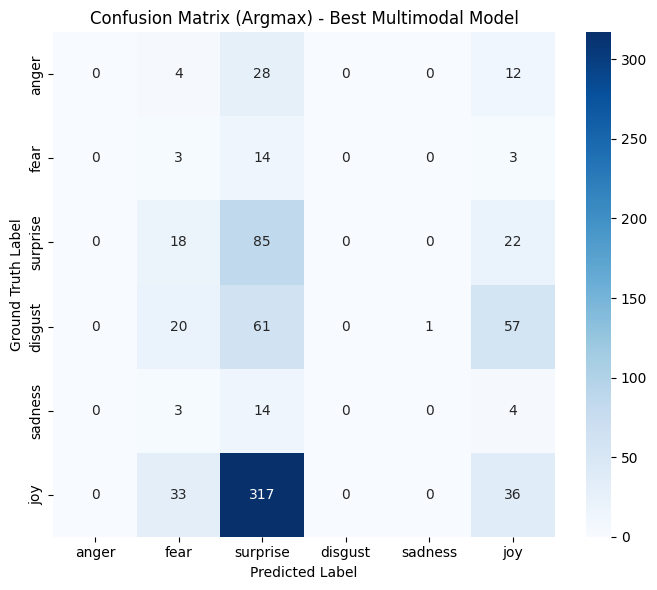

In [59]:
gt_labels = []
pred_labels = []

def get_argmax_label(dist):
    return np.argmax(dist) if dist is not None else None

for idx, row in df.iterrows():
    gt = row["gt_dist"]
    pred = row["best_multi_dist"]
    if gt is None or pred is None:
        continue
    gt_label = get_argmax_label(gt)
    pred_label = get_argmax_label(pred)
    gt_labels.append(gt_label)
    pred_labels.append(pred_label)

# Build the confusion matrix
cm = confusion_matrix(gt_labels, pred_labels, labels=[0,1,2,3,4,5])

# Convert it into a pandas DataFrame for labeling
cm_df = pd.DataFrame(cm, index=EMOTIONS, columns=EMOTIONS)

plt.figure(figsize=(7, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Argmax) - Best Multimodal Model")
plt.xlabel("Predicted Label")
plt.ylabel("Ground Truth Label")
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd

In [68]:
df = pd.read_csv("/Users/pranavtyagi/Projects/masterthesis/data/predictions/aug/predictions_replies_cardiffnlp_twitter-roberta-large-emotion-latest_merged.csv")

In [78]:
print(df[df['conversation_id']==1166008123263475712]['replies'].to_list())
print(df[df['conversation_id']==1166008123263475712]['mapped_predictions'].to_list())

['_ Enlightenment at a time when the world began to turn towards fires, it turns out that fires broke out in entire countries in sub-Saharan Africa, as well as a large area of']
["[('anger', 0.06943728003861536), ('fear', 0.4878813124112428), ('surprise', 0.06856447208246866), ('disgust', 0.042120958481662855), ('sadness', 0.30462123612702724), ('joy', 0.027374740858983088)]"]


In [79]:
print(df[df['conversation_id']==1161715780523896832]['replies'].to_list())
print(df[df['conversation_id']==1161715780523896832]['mapped_predictions'].to_list())

['p s this really matters for']
["[('anger', 0.049830309993476894), ('fear', 0.07396296118073008), ('surprise', 0.6238990958582076), ('disgust', 0.09734621570357044), ('sadness', 0.08663677708750524), ('joy', 0.06832464017650974)]"]


In [80]:
print(df[df['conversation_id']==1158365774362415110]['replies'].to_list())
print(df[df['conversation_id']==1158365774362415110]['mapped_predictions'].to_list())

['great work even if it highlights a worrying trend', 'thank you very much i have been producing it every month for the lastyears hoping people will notice think and act they are like blindfolded deer in the headlights of an semi truck with no ie what is coming this is planetary transformation inlifetime', ' BASIL AMAELO????', 'that line fills me with dread', 'the planet amp all that inhabit it are in a world of trouble now all the moneyed interests want to make a buck out of this crisis', 'nibiu close eath', 'the status quo is a desperate gamble we need disruptive change', 'how would you propose dissolving them they do provide some necessary services', 'if corporations are going to be part of the solution they need to stop pretending and collectively look at the system in which they operate it is broken', 'this seems off', 'i wish it was you can check the data for yourself by downloading it from the polar science here', 'very pretty and inventive after looking at it for a while i saw 

In [82]:

print(df[df['conversation_id']==1165556946180694016]['replies'].to_list())
print(df[df['conversation_id']==1165556946180694016]['mapped_predictions'].to_list())

['this is stupid', 'why i thought they believed that everything is climate change', ' Snow in Texas!', 'why let us hear what each has to contribute', 'now who are the climate change deniers', 'i appreciate their effort in losing as many elections as possible', 'i found the article hard to read i am no dummy but neither am i the brightest bulb', 'go be irritated on breitbart breitbart and faux noise are for trump dummies cuz trump dummies just believe', 'candidates should be able to weave climate change concerns and policy ideas into every topic that comes up healthcare easy infrastructure easy economy easy job creation easy it should not be that difficutl bring it up throughout', 'dnc no commentsame trough', 'still trump and the cult', 'because it makes them look stupid', 'dnc is such a fascist organization they preventing their own members from exercising free speech if democrats had any integrity or courage they would tell their fascist dnc puppet masters to go pound sand sadly dems 

In [ ]:
df = pd.read_csv("/Users/pranavtyagi/Projects/masterthesis/data/predictions/aug/test_predictions_with_metrics_multi.csv")

In [ ]:
df.sort_values('kl_divergence', ascending=False)['conversation_id'][:50].to_list()

[1162907877566078976,
 1164975729685258240,
 1165573490172411904,
 1165641643044810754,
 1162622105730584577,
 1166260347399016448,
 1166984816916611072,
 1158973733396258817,
 1167277890624512000,
 1159459240312016896,
 1158407987532357632,
 1165770011107090432,
 1162406476637507585,
 1167178862347743232,
 1159834398474133505,
 1162454367301251072,
 1159127272596615168,
 1159149155987730432,
 1167550220814565376,
 1158401854411350019,
 1161672122583830528,
 1159104393423327233,
 1160181605085908992,
 1167111876779630593,
 1163483279972098048,
 1163985331798073345,
 1163535256215007234,
 1159831976909692929,
 1163156103900934147,
 1162987499632902144,
 1166681837021749256,
 1163119757526208513,
 1160429905961574405,
 1157341588860706822,
 1158835985582419968,
 1162779931652362243,
 1163888429433647104,
 1160920675281805313,
 1166944080149876743,
 1163884154121072648,
 1162038488889470976,
 1159952367254724608,
 1158476748050370561,
 1160370814987976705,
 1160539733950455808,
 116523024

In [ ]:
dff = tweets_df[tweets_df['conversation_id'].isin(df.sort_values('kl_divergence', ascending=False)['conversation_id'][:50].to_list())].copy()

1166008123263475712
Image not found for conversation_id: 1166008123263475712
Tweet 1: #AlTenoorOverflow #Africafires#Angola#Zambia#Tanzania#CongoLinks to the #SkirmishEvents statements in multiple languages:[URL] [URL]
Tweet Distribution: {'anger': 0.21514056, 'fear': 0.15376969, 'surprise': 0.34307328, 'disgust': 0.11004311, 'sadness': 0.09483379, 'joy': 0.08313957}
CLIP Distribution: {'anger': 0.26606992, 'fear': 0.3789367, 'surprise': 0.12640072, 'disgust': 0.11808189, 'sadness': 0.05766713, 'joy': 0.052843694}
Average Distribution: {'anger': 0.24060524, 'fear': 0.2663532, 'surprise': 0.234737, 'disgust': 0.1140625, 'sadness': 0.07625046, 'joy': 0.06799163}
Predicted Distribution: {'anger': 0.1088891, 'fear': 0.27045786, 'surprise': 0.2549178, 'disgust': 0.0991774, 'sadness': 0.10598014, 'joy': 0.16057767}
reply Distribution: {'anger': 0.06943728, 'fear': 0.48788131, 'surprise': 0.06856447, 'disgust': 0.04212096, 'sadness': 0.30462124, 'joy': 0.02737474}
JSD tweet: 0.479598556214591

KeyError: 'jsd_model'

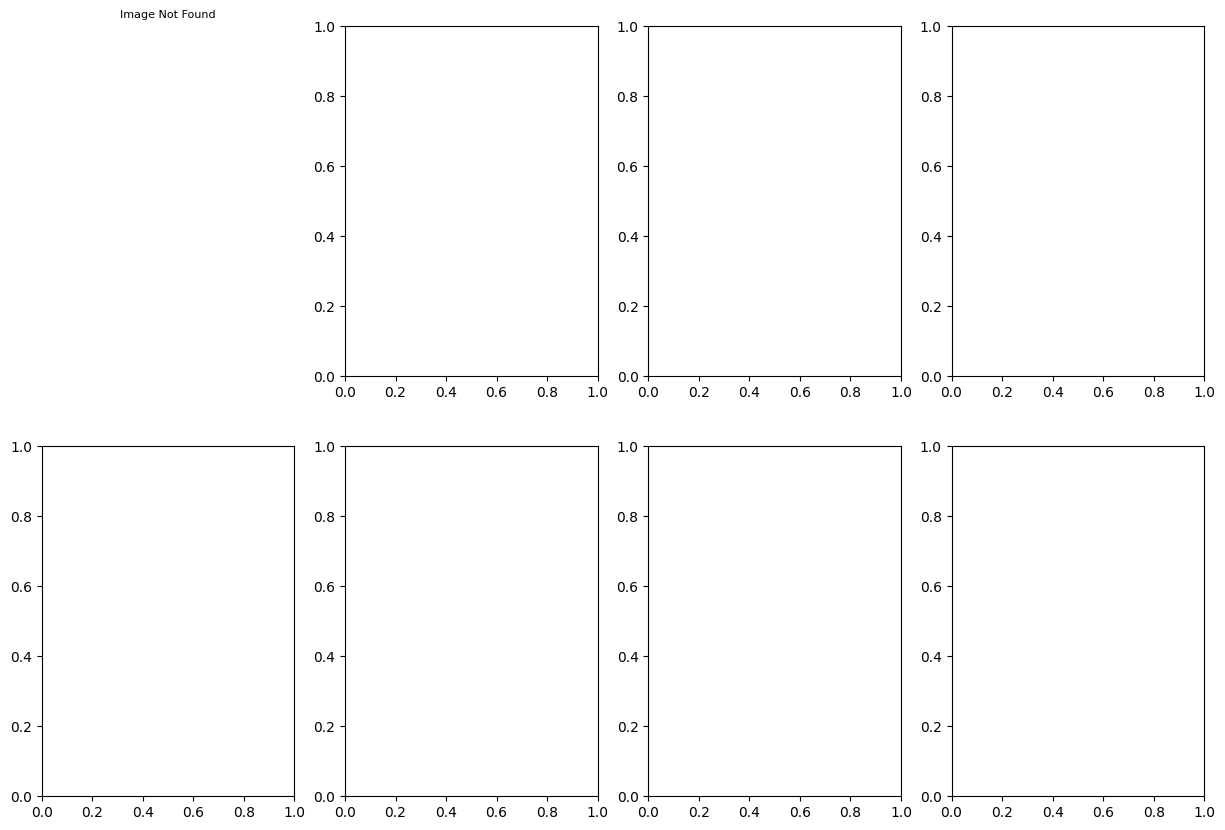

In [ ]:
visualize_tweets(dff)

In [58]:
predictions_df=pd.read_csv("/Users/pranavtyagi/Projects/masterthesis/data/predictions_aug.csv")

In [59]:
df = df.merge(predictions_df[["conversation_id", "average_reply_distribution"]], on="conversation_id")

In [60]:
def parse_predictions(pred_str):
    return dict(ast.literal_eval(pred_str))

df['mapped_predictions'] = df['mapped_predictions'].apply(parse_predictions)

In [61]:
def parse_predictions(pred_str):
    return ast.literal_eval(pred_str)

df['average_reply_distribution'] = df['average_reply_distribution'].apply(parse_predictions)

In [62]:
df[["id","conversation_id","replies","tweet_text","mapped_predictions","average_reply_distribution"]]

,id,conversation_id,replies,tweet_text,mapped_predictions,average_reply_distribution
0,1156746119180902400,1156745986548670465,oh my god it totally was,Quote of the night? Gillibrand gets laughs say...,"{'anger': 0.08780127016028874, 'fear': 0.22526...","{'anger': 0.16990943452855908, 'fear': 0.05985..."
1,1156746144963280896,1156745986548670465,before or after she does her hair,Quote of the night? Gillibrand gets laughs say...,"{'anger': 0.015570776389623047, 'fear': 0.0438...","{'anger': 0.16990943452855908, 'fear': 0.05985..."
2,1156746151435149312,1156745986548670465,we did that,Quote of the night? Gillibrand gets laughs say...,"{'anger': 0.007062669697876885, 'fear': 0.0038...","{'anger': 0.16990943452855908, 'fear': 0.05985..."
3,1156746252362510337,1156745986548670465,try exorcism,Quote of the night? Gillibrand gets laughs say...,"{'anger': 0.10408256350080972, 'fear': 0.18674...","{'anger': 0.16990943452855908, 'fear': 0.05985..."
4,1156746475994529797,1156745986548670465,i am very unsurprised that the times would lik...,Quote of the night? Gillibrand gets laughs say...,"{'anger': 0.1280327484074636, 'fear': 0.044025...","{'anger': 0.16990943452855908, 'fear': 0.05985..."
...,...,...,...,...,...,...
4472,1167937292977070080,1167521202170138624,i suspect it is because the horrific project w...,Has [USER] forgotten about #ClimateChange as i...,"{'anger': 0.1607892100883772, 'fear': 0.473827...","{'anger': 0.26615668444124435, 'fear': 0.19349..."
4473,1167942016585461760,1167458952268963841,you wish i were just a troll but why why,How will history judge those who challenge the...,"{'anger': 0.34005159486586134, 'fear': 0.06067...","{'anger': 0.23754844846564038, 'fear': 0.08205..."
4474,1167944216690880513,1167458952268963841,climate change can not be proven amp those who...,How will history judge those who challenge the...,"{'anger': 0.21009403537641289, 'fear': 0.44104...","{'anger': 0.23754844846564038, 'fear': 0.08205..."
4475,1167944597038755840,1167458952268963841,but you want people who draw conclusions diffe...,How will history judge those who challenge the...,"{'anger': 0.43006238704131305, 'fear': 0.03541...","{'anger': 0.23754844846564038, 'fear': 0.08205..."


       reply_length  num_replies  prediction_entropy  avg_reply_entropy
count   4477.000000  4477.000000         4477.000000        4477.000000
mean     108.762117    58.311593            1.703332           2.220517
std       44.916506    70.645654            0.521798           0.417109
min        3.000000     1.000000            0.215232           0.234244
25%       71.798319     6.000000            1.499359           2.212724
50%      109.520000    21.000000            1.829985           2.390885
75%      145.048780   111.000000            2.077944           2.430338
max      290.000000   238.000000            2.534136           2.550715


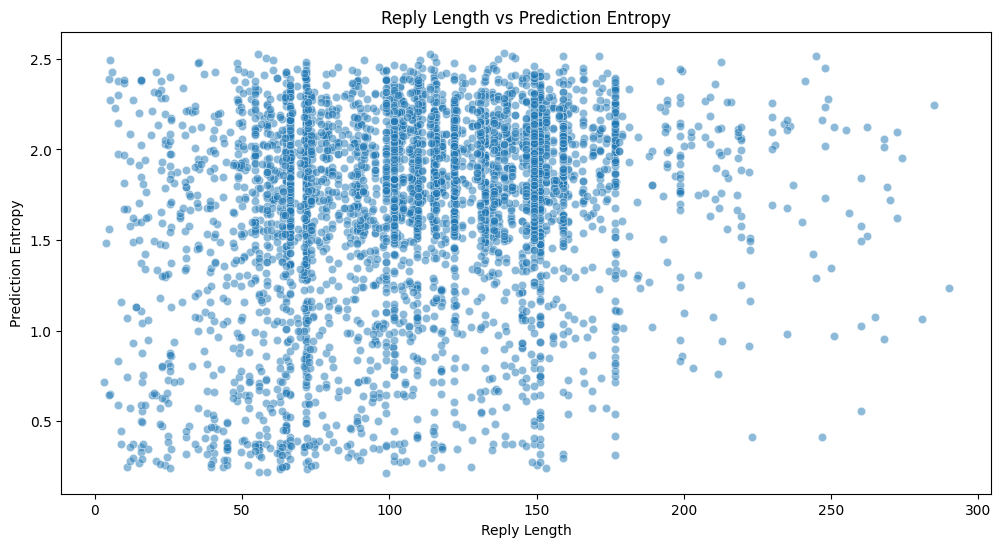

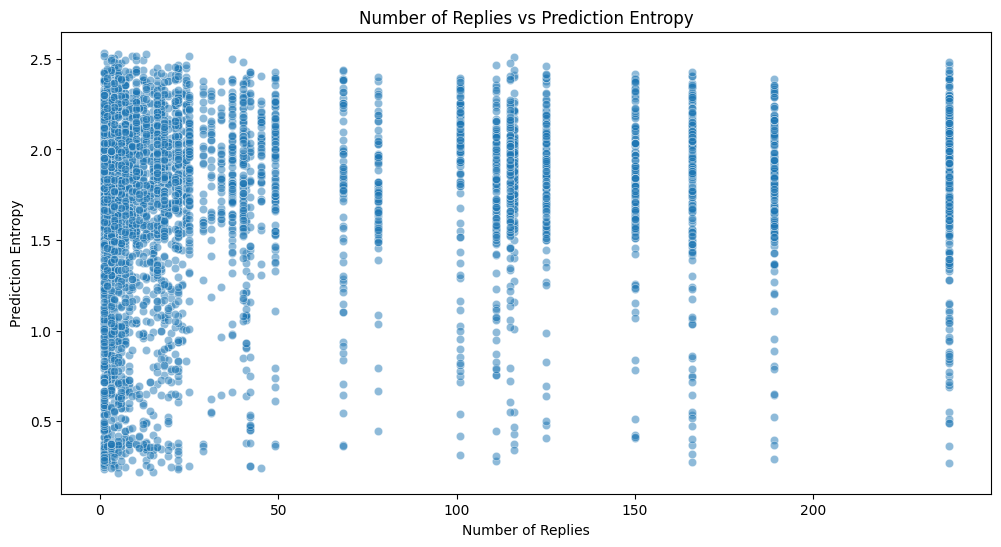

                   num_replies  reply_length  avg_reply_entropy
num_replies           1.000000     -0.030891           0.363068
reply_length         -0.030891      1.000000           0.279107
avg_reply_entropy     0.363068      0.279107           1.000000


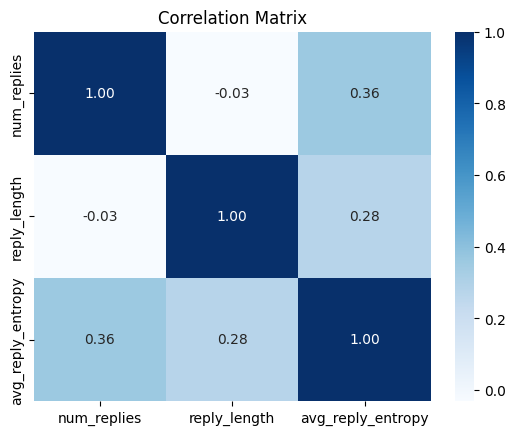

In [67]:
import pandas as pd
import numpy as np
import json
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate entropy from a dictionary of probabilities
def compute_entropy(prediction_dict):
    if isinstance(prediction_dict, str):
        prediction_dict = json.loads(prediction_dict)  # Convert from string if needed
    probs = np.array(list(prediction_dict.values()))
    return entropy(probs, base=2)

# Compute reply lengths
df["reply_length"] = df.groupby("conversation_id")["replies"].transform(lambda x: x.str.len().mean())

# Compute additional features
df["num_replies"] = df.groupby("conversation_id")["id"].transform("count")
df["prediction_entropy"] = df["mapped_predictions"].apply(compute_entropy)
df["avg_reply_entropy"] = df["average_reply_distribution"].apply(compute_entropy)

# Descriptive statistics
print(df[["reply_length", "num_replies", "prediction_entropy", "avg_reply_entropy"]].describe())

# Visualization
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="reply_length", y="prediction_entropy", alpha=0.5)
plt.xlabel("Reply Length")
plt.ylabel("Prediction Entropy")
plt.title("Reply Length vs Prediction Entropy")
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="num_replies", y="prediction_entropy", alpha=0.5)
plt.xlabel("Number of Replies")
plt.ylabel("Prediction Entropy")
plt.title("Number of Replies vs Prediction Entropy")
plt.show()

# Correlation analysis
correlation_matrix = df[["num_replies", "reply_length", "avg_reply_entropy"]].corr()
print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [2]:
import pandas as pd

In [94]:

import re

# Function to extract experiment components
def extract_experiment_components(exp_name):
    components = {
        "optimizer": "",
        "model": "",
        "lr": "",
        "dropout": "",
        "activation": "",
        "epochs": "",
        "frozen": False,
        "bigger_mlp": False,
        "hierarchical": False,
        "clip": False,
        "roberta": False
    }
    
    parts = exp_name.split("_")
    
    for part in parts:
        if part in ["adamw", "sgd", "rmsprop"]:
            components["optimizer"] = part
        elif "roberta" in part:
            components["model"] = part
        elif part.startswith("lr"):
            components["lr"] = part[2:]
        elif part.startswith("drop"):
            components["dropout"] = part[4:]
        elif part in ["gelu", "relu"]:
            components["activation"] = part
        elif part.startswith("epochs"):
            components["epochs"] = part[6:]
        elif part == "frozen":
            components["frozen"] = True
        elif part == "bigger" or part == "mlp":
            components["bigger_mlp"] = True
        elif part == "hierarchical":
            components["hierarchical"] = True
        elif part == "clip":
            components["clip"] = True
        elif part == "roberta":
            components["roberta"] = True
    
    return components

# Load CSV file
df = pd.read_csv("/Users/pranavtyagi/Projects/masterthesis/data/multi_exp.csv")

# Extract experiment components
exp_details = df["experiment"].apply(extract_experiment_components).apply(pd.Series)

# Merge extracted components with the original metrics
df_final = pd.concat([df, exp_details], axis=1)

In [7]:
df = pd.read_csv("/Users/pranavtyagi/Projects/masterthesis/data/multi_exp.csv")

In [8]:


# Round all numeric columns to 4 decimal places
df = df.round(4)

# Save the modified CSV file
df.to_csv('rounded_file.csv', index=False)



In [97]:
df

,experiment,Test/Cosine_Sim,Test/KL_Div,Test/MSE,Test/Cosine_Sim_Norm,Test/MSE_Norm,Test/KL_Div_Norm,score
0,exp_adamw_roberta_large_lr1e-05_drop0.5_bigger...,0.8126,0.3363,0.0224,0.8126,0.9776,0.6637,2.4539
1,exp_adamw_roberta_base_lr5e-06_drop0.3_gelu_ep...,0.8115,0.3370,0.0223,0.8115,0.9777,0.6630,2.4522
2,exp_adamw_roberta_large_lr1e-05_drop0.5_gelu_e...,0.8114,0.3385,0.0225,0.8114,0.9775,0.6615,2.4504
3,exp_adamw_roberta_base_lr5e-06_drop0.5_epochs2...,0.8120,0.3393,0.0225,0.8120,0.9775,0.6607,2.4502
4,exp_adamw_roberta_large_lr1e-05_drop0.3_gelu_e...,0.8110,0.3383,0.0225,0.8110,0.9775,0.6617,2.4501
...,...,...,...,...,...,...,...,...
267,exp_adamw_roberta_large_lr1e-05_drop0.3_bigger...,0.7710,0.4261,0.0279,0.7710,0.9721,0.5739,2.3170
268,exp_adamw_roberta_large_lr1e-05_drop0.3_epochs5,0.7712,0.4281,0.0279,0.7712,0.9721,0.5719,2.3152
269,exp_roberta_large_lr1e-05_drop0.3_epochs5,0.7679,0.4264,0.0279,0.7679,0.9721,0.5736,2.3135
270,exp_adamw_roberta_large_lr1e-05_drop0.3_gelu_e...,0.7711,0.4344,0.0282,0.7711,0.9718,0.5656,2.3085
